# Motivating figure

In [1]:
import jax
import datagen
import jax.numpy as jnp
import matplotlib.pyplot as plt

from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

## Process sample

In [3]:
key = jax.random.PRNGKey(314)

In [545]:
delta = 1
dynamics_covariance = 0.1
obs_covariance = 1.0
outlier_scale = 2.0
dgen = datagen.GaussMeanOutlierMovingObject2D(
    delta, dynamics_covariance, obs_covariance,
    outlier_proba=0.0,
    outlier_scale=outlier_scale,
)


In [546]:
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])

n_steps = 20
dataset = dgen.sample(key, initial_mean, n_steps)

measurements_clean = dataset["observed"]
state = dataset["latent"]

xout = jnp.array([5, 10, 15])

measurements = measurements_clean[xout] * outlier_scale * jnp.array([-1, 1, -1])[:, None]
measurements = measurements_clean.at[xout].set(measurements)

In [547]:
ix = 1
y = measurements[:, ix]
yout = y[xout]

xrange = jnp.arange(n_steps)
is_outlier = jnp.isin(xrange, xout)

Text(0.5, 0, 'time')

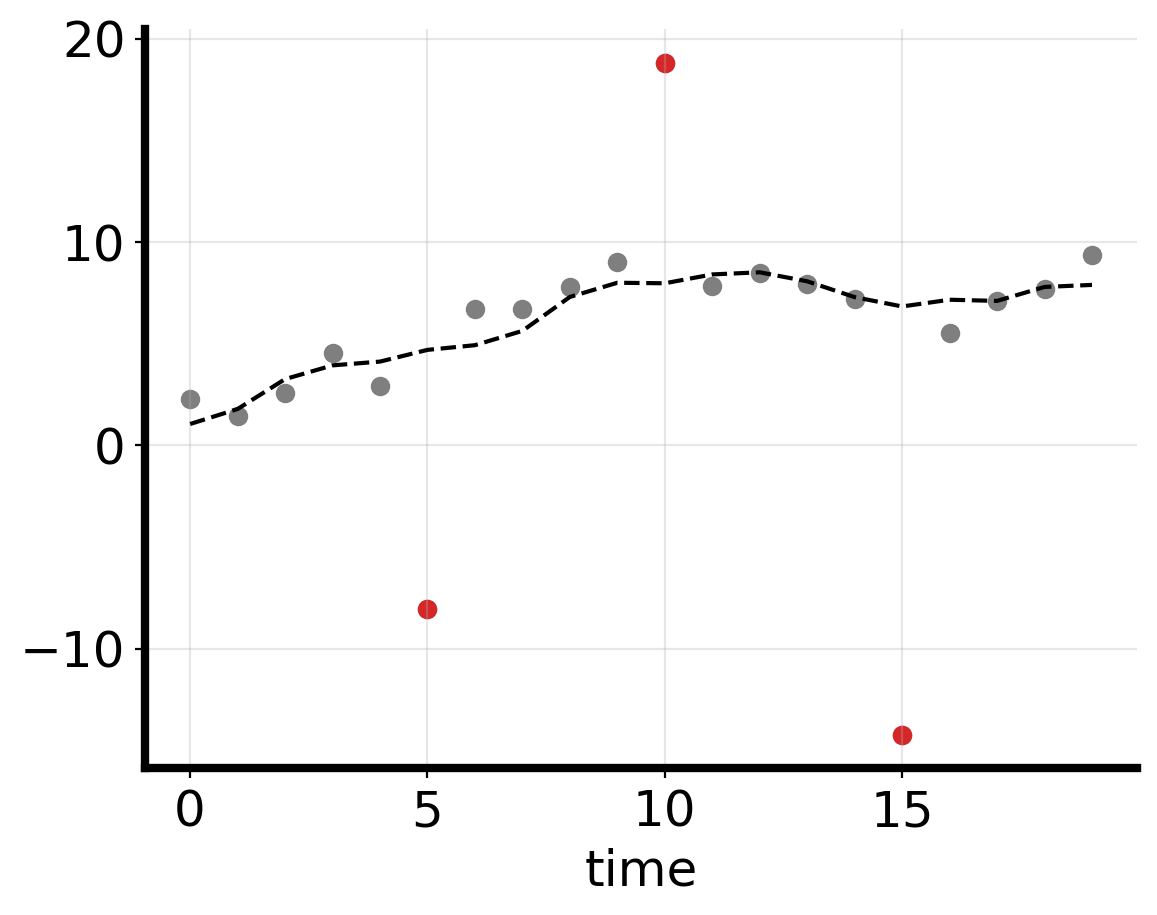

In [548]:
plt.plot(y, c="tab:gray", label="measurement", marker="o", linewidth=0, zorder=0)
plt.plot(state[:, ix], c="black", linestyle="--", label="state")
plt.scatter(xout, yout, c="tab:red")
plt.grid(alpha=0.3)
plt.xlabel("time")

In [549]:
agent_kf = kf.KalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance
)

init_bel = agent_kf.init_bel(initial_mean, cov=1.0)

bel, hist_noisy = agent_kf.scan(
    init_bel, measurements, dgen.projection_matrix,
    callback
)

## IMQ filter

In [550]:
def link(z, _):
    mean = dgen.projection_matrix @ z
    return mean


def callback(bel_update, bel_prev, y, x):
    return bel_update

In [551]:
soft_threshold = 2.0

agent_imq = gbf.IMQFilter(
    link,
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    soft_threshold=soft_threshold,
    transition_matrix=dgen.transition_matrix,
)

init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
_, hist = agent_imq.scan(init_bel, measurements, jnp.ones(n_steps), callback_fn=callback)

In [552]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.linewidth"] = 3

In [553]:
xrange = jnp.arange(0, n_steps)

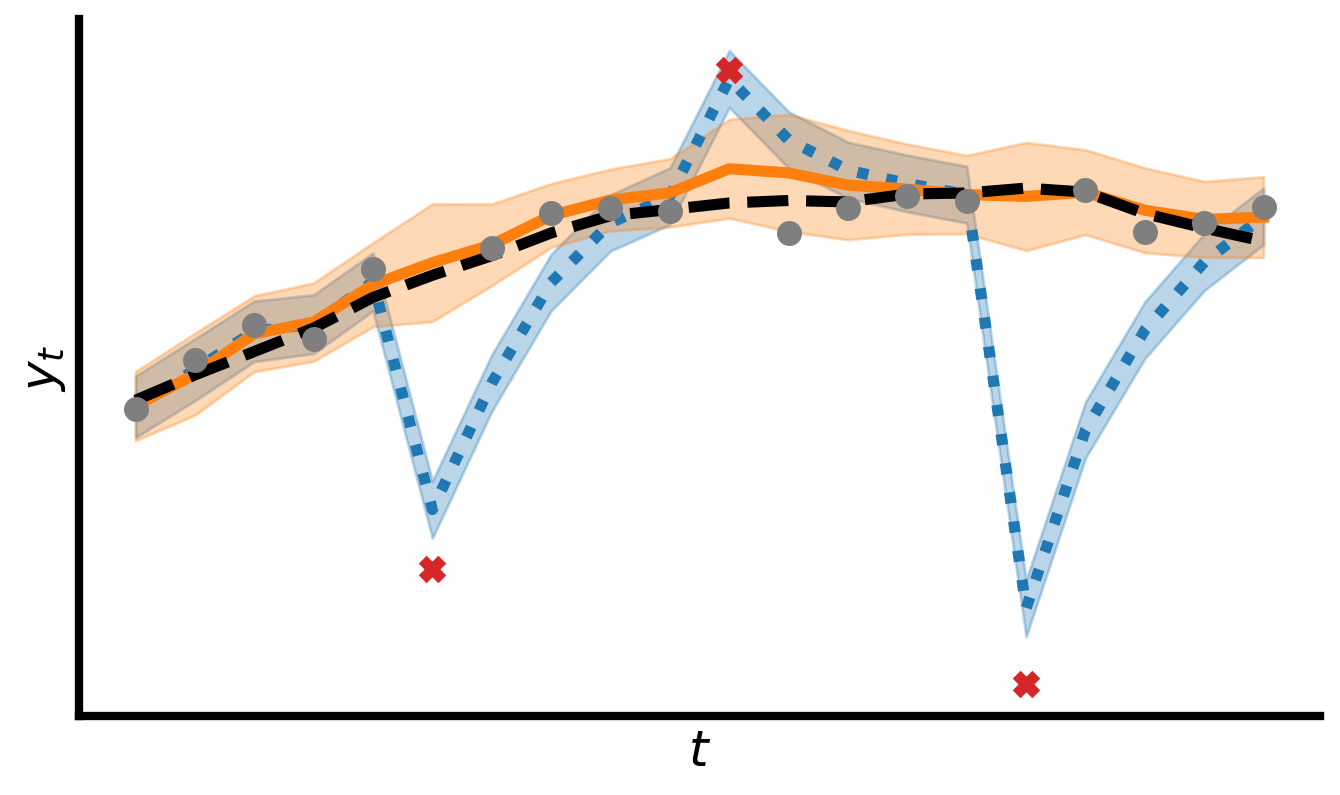

In [554]:
lw = 4
ix = 0
fig, ax = plt.subplots(figsize=(6.4 * 1.1, 4.8 * 0.9))

y = measurements[:, ix]

std_kf = jnp.sqrt(hist_noisy.cov[:, ix, ix])
std_wlkf = jnp.sqrt(hist.covariance[:, ix, ix])


ubound =  hist_noisy.mean[:, ix] + 2  * std_kf
lbound =  hist_noisy.mean[:, ix] - 2 * std_kf
plt.fill_between(xrange, ubound, lbound, color="C0", alpha=0.3)
plt.plot(xrange, hist_noisy.mean[:, ix], c="C0", label="KF", linewidth=lw, linestyle="dotted")


ubound =  hist.mean[:, ix] + 2 * std_wlkf
lbound =  hist.mean[:, ix] - 2 * std_wlkf
plt.fill_between(xrange, ubound, lbound, color="C1", alpha=0.3)
plt.plot(xrange, hist.mean[:, ix], c="C1", label="WLF", linewidth=lw)


plt.plot(xrange, state[:, ix], c="black", linestyle="--", label="KF-clean", linewidth=lw)

# Plot outliers
plt.plot(xrange[~is_outlier], y[~is_outlier], c="tab:gray", marker="o", linewidth=0, markersize=8)
plt.scatter(xout, yout, c="tab:red", zorder=3, s=50, marker="x", linewidth=4)

# plt.grid(alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.ylabel("$y_t$")
plt.xlabel("$t$")
plt.tight_layout()
plt.savefig("./figures/intro-plot.png", dpi=300)
# plt.legend(loc="upper left", fontsize=13)

## PIF effect

In [555]:
from matplotlib.colors import Normalize
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [556]:
soft_threshold = 2.0
agent = kf.KalmanFilter(
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    transition_matrix=dgen.transition_matrix,
)

init_bel = agent.init_bel(initial_mean, cov=1.0)
bel_base, _ = agent.scan(init_bel, measurements_clean, dgen.projection_matrix)

norm_base = tfd.MultivariateNormalFullCovariance(loc=bel_base.mean, covariance_matrix=bel_base.cov)

In [557]:
from rebayes_mini.methods import robust_filter as rfilter

In [572]:
xout = -1
@jax.jit
def pif_last(verr):    
    measurements = measurements_clean.at[xout].set(measurements_clean[xout] + verr)

    soft_threshold = 3.0
    agent_imq = rfilter.ExtendedKalmanFilterIMQ(
        lambda x: dgen.transition_matrix @ x,
        link,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
    )

    init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
    bel_imq, _ = agent_imq.scan(init_bel, measurements, jnp.ones(n_steps))

    norm_imq = tfd.MultivariateNormalFullCovariance(loc=bel_imq.mean, covariance_matrix=bel_imq.cov)
    

    threshold = 6
    agent_md = rfilter.ExtendedKalmanFilterMD(
        lambda x: dgen.transition_matrix @ x,
        link,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold,
    )

    init_bel = agent_md.init_bel(initial_mean, cov=1.0)
    bel_md, _ = agent_md.scan(init_bel, measurements, jnp.ones(n_steps))

    norm_md = tfd.MultivariateNormalFullCovariance(loc=bel_md.mean, covariance_matrix=bel_md.cov)
    

    agent_kf = kf.KalmanFilter(
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        transition_matrix=dgen.transition_matrix,
    )

    init_bel = agent_kf.init_bel(initial_mean, cov=1.0)
    bel_kf, _ = agent_kf.scan(init_bel, measurements, dgen.projection_matrix)

    norm_kf = tfd.MultivariateNormalFullCovariance(loc=bel_kf.mean, covariance_matrix=bel_kf.cov)

    
    res = {
        "IMQ": norm_base.kl_divergence(norm_imq),
        "MD": norm_base.kl_divergence(norm_md),
        "KF": norm_base.kl_divergence(norm_kf),
    }
    
    return res

In [576]:
%%time
step = 0.1
vmin, vmax = -7, 7 + step
vals = jnp.mgrid[vmin:vmax:step, vmin:vmax:step]

res = jax.vmap(jax.vmap(pif_last, 1), 2)(vals)
res = jax.block_until_ready(res)
# res = jax.tree_map(jnp.log, res)

CPU times: user 33.8 s, sys: 799 ms, total: 34.6 s
Wall time: 5.75 s


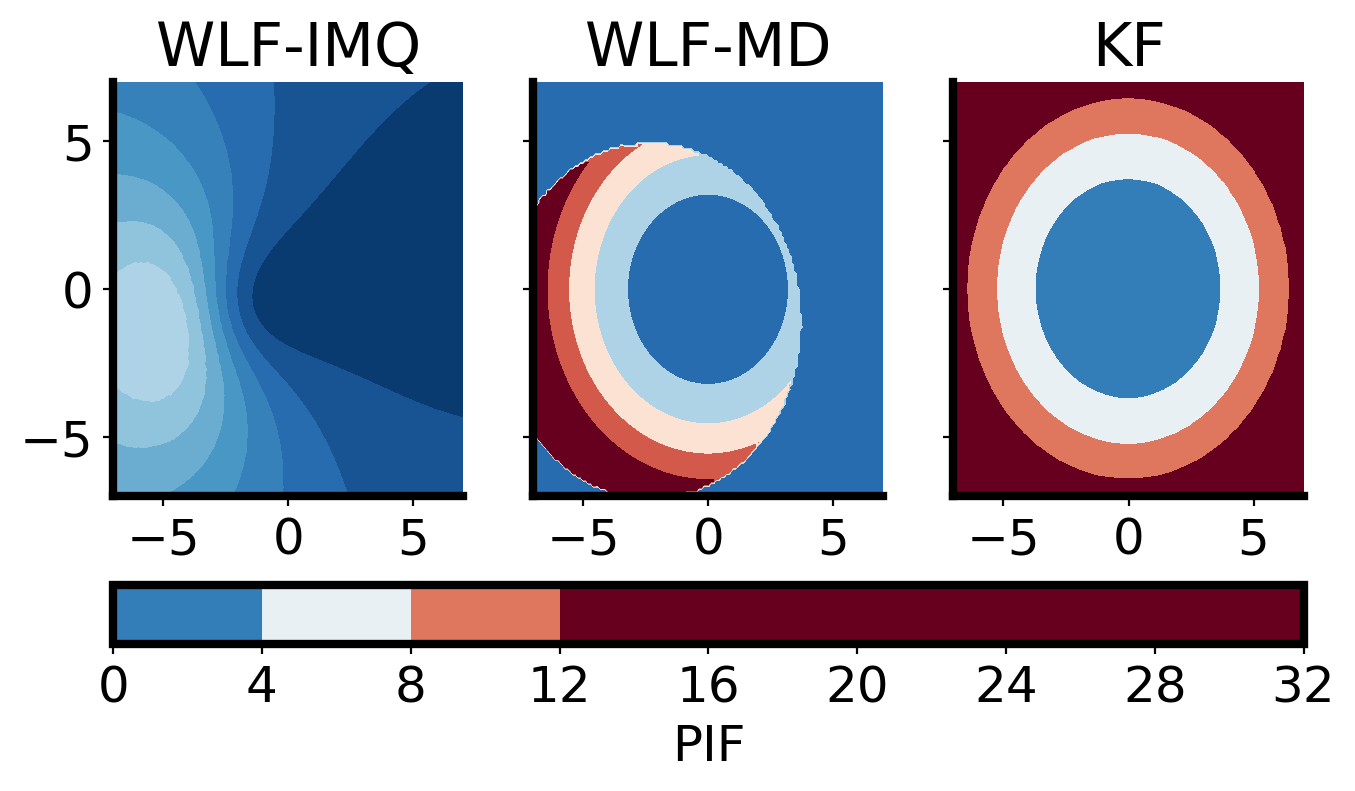

In [580]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(6.4 * 1.2, 4.8 * 0.8),)
norm = Normalize(0, 13)
cmap = "RdBu_r"
c0 = ax[0].contourf(*vals, res["IMQ"], cmap=cmap, norm=norm)
c1 = ax[1].contourf(*vals, res["MD"], cmap=cmap, norm=norm)
c2 = ax[2].contourf(*vals, res["KF"], cmap=cmap, norm=norm)
ax[0].set_title("WLF-IMQ")
ax[1].set_title("WLF-MD")
ax[2].set_title("KF")
plt.colorbar(c2, ax=ax, location="bottom", label="PIF")
plt.savefig("./figures/pif-2d-tracking.png", dpi=300)